
#Importing nesessary libraries



In [ ]:
import pandas as pd  
import numpy as np   
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore")
from google.colab import files
import itertools

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from tensorflow.keras.layers import  Dropout, Dense
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, f1_score

#loading the pre processed dataset


*   Most of the feature engineering was done through **PowerBI** and **R Studio**



In [ ]:
train = pd.read_csv("/content/train.csv")
valid = pd.read_csv("/content/validation.csv")
test = pd.read_csv("/content/test.csv")

# Data preprocess

Printing the first 5 rows

In [ ]:
train.head()

,Age,Educational_Level,Income,Expected_checkin,Expected_checkout,Booking_date,Adults,Children,Babies,Meal_Type,Visted_Previously,Previous_Cancellations,Required_Car_Parking,Use_Promotion,Discount_Rate,Room_Rate,is_female,Is_Latino,Is_caucasian,Is_African American,Is_Asian American,East,North,South,West,Airport Hotels,City Hotel,Resort,Deposit_type,Agent,Online,Direct,Reservation_Status,Total_People,Rooms_Needed,Total_Days_Staying,Total_Room_Rate,Days_since_Booking,WeekDay,Staying_in_Weekend,Checkin_Year,Checkin_Month
0,18,1,1,"Monday, May 30, 2016","Tuesday, May 31, 2016","Monday, October 19, 2015",2,2,0,1,0,0,1,1,10,129,1,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,4,1,1,116.10,224,1,0,2016,5
1,18,2,4,"Monday, April 4, 2016","Tuesday, April 5, 2016","Monday, October 19, 2015",2,2,0,1,0,0,1,1,25,130,1,0,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0,4,1,1,97.50,168,1,0,2016,4
2,18,3,1,"Monday, April 18, 2016","Tuesday, April 19, 2016","Tuesday, November 10, 2015",2,2,0,1,0,0,1,1,25,114,1,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,4,1,1,85.50,160,1,0,2016,4
3,18,3,3,"Thursday, March 24, 2016","Friday, March 25, 2016","Saturday, November 21, 2015",2,2,0,1,0,0,1,0,0,181,1,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,4,1,1,181.00,124,4,0,2016,3
4,18,3,3,"Saturday, July 30, 2016","Sunday, July 31, 2016","Friday, January 22, 2016",2,2,0,1,0,0,1,1,25,205,1,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,4,1,1,153.75,190,6,1,2016,7


Description of the columns

In [ ]:
train.describe()

,Age,Educational_Level,Income,Adults,Children,Babies,Meal_Type,Visted_Previously,Previous_Cancellations,Required_Car_Parking,Use_Promotion,Discount_Rate,Room_Rate,is_female,Is_Latino,Is_caucasian,Is_African American,Is_Asian American,East,North,South,West,Airport Hotels,City Hotel,Resort,Deposit_type,Agent,Online,Direct,Reservation_Status,Total_People,Rooms_Needed,Total_Days_Staying,Total_Room_Rate,Days_since_Booking,WeekDay,Staying_in_Weekend,Checkin_Year,Checkin_Month
count,27499.000000,27499.000000,27499.000000,27499.000000,27499.000000,27499.000000,27499.000000,27499.000000,27499.000000,27499.000000,27499.000000,27499.000000,27499.000000,27499.000000,27499.000000,27499.000000,27499.000000,27499.000000,27499.000000,27499.000000,27499.000000,27499.000000,27499.000000,27499.000000,27499.000000,27499.000000,27499.000000,27499.000000,27499.000000,27499.000000,27499.000000,27499.000000,27499.000000,27499.000000,27499.000000,27499.000000,27499.000000,27499.000000,27499.000000
mean,43.977454,2.598531,2.294738,2.333576,1.743882,0.351540,1.671624,0.332921,0.113459,0.713808,0.751664,12.495182,175.136478,0.501800,0.247500,0.250555,0.253282,0.248664,0.198553,0.206189,0.396996,0.198262,0.336667,0.332158,0.331176,1.590531,0.144842,0.566348,0.288811,0.304884,4.077457,1.158879,1.836212,325.608228,109.910906,3.854213,0.516237,2015.820212,6.248773
std,15.303148,1.017302,1.028755,1.176526,0.721972,0.573326,0.773515,0.471267,0.317158,0.451989,0.432056,11.206036,43.877087,0.500006,0.431567,0.433340,0.434899,0.432246,0.398918,0.404575,0.489284,0.398698,0.472578,0.470996,0.470645,0.865897,0.351947,0.495587,0.453218,0.605388,1.377941,0.365569,0.985204,236.377584,78.048838,2.001913,0.499745,0.648410,3.308221
min,18.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,60.000000,-4.000000,1.000000,0.000000,2014.000000,1.000000
25%,31.000000,2.000000,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,5.000000,137.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,1.000000,162.350000,45.000000,2.000000,0.000000,2015.000000,3.000000
50%,44.000000,3.000000,2.000000,2.000000,2.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,10.000000,175.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,4.000000,1.000000,2.000000,244.800000,101.000000,4.000000,1.000000,2016.000000,6.000000
75%,57.000000,3.000000,3.000000,3.000000,2.000000,1.000000,2.000000,1.000000,0.000000,1.000000,1.000000,20.000000,214.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,3.000000,0.000000,1.000000,1.000000,0.000000,5.000000,1.000000,2.000000,419.400000,166.000000,5.000000,1.000000,2016.000000,9.000000
max,70.000000,4.000000,4.000000,5.000000,3.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,40.000000,250.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,2.000000,8.000000,2.000000,4.000000,1992.000000,708.000000,7.000000,1.000000,2017.000000,12.000000


Observe the Age feature

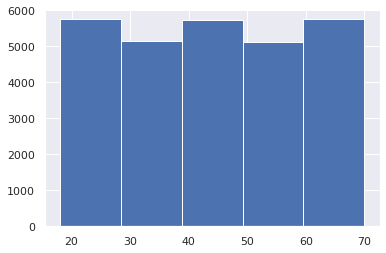

In [ ]:
train.Age.hist(bins=5)

Defining a function to divide the ages into bins

In [ ]:
def func(val):
  if (val<30):
    return 0
  elif (val<40):
    return 1
  elif (val<50):
    return 2
  elif (val<60):
    return 3
  else: 
    return 34

Applying the function to bin age column

In [ ]:
train['Age_bin'] = train.Age.apply(func)
valid['Age_bin'] = valid.Age.apply(func)
test['Age_bin'] = test.Age.apply(func)

Plotting count plots to understand data imbalance

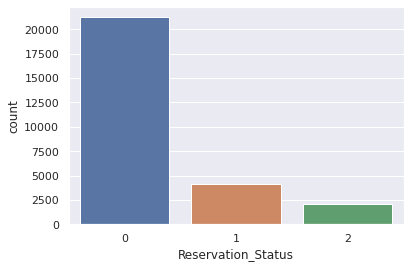

In [ ]:
sns.countplot(train.Reservation_Status)

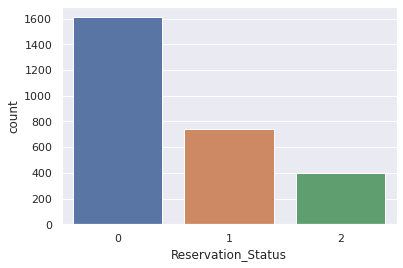

In [ ]:
sns.countplot(valid.Reservation_Status)

Dropping features to reduce multicollinearity

In [ ]:
drop_cols = ['Is_Latino', 'East', 'Expected_checkin','WeekDay', 'Total_Days_Staying', 
             'Checkin_Year','Expected_checkout', 'Age', 'Booking_date', 'Total_People', 'Resort', 
             'Agent', 'Use_Promotion', 'Room_Rate', 'Rooms_Needed']
# drop_cols = ['Expected_checkin','Expected_checkout', 'Booking_date']
train.drop(drop_cols, axis=1, inplace=True)
valid.drop(drop_cols, axis=1, inplace=True)
test.drop(drop_cols, axis=1, inplace=True)

In [ ]:
train.shape

(27499, 40)

Dividing the features and the target

In [ ]:
X_train = train.drop('Reservation_Status',axis=1)
y_train = train.Reservation_Status
X_valid = valid.drop('Reservation_Status',axis=1)
y_valid = valid.Reservation_Status

columns = X_train.columns

Applying the scaling for all the features

In [ ]:
scaler = MinMaxScaler()
# scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(test)

Applying the SMOTE upsamling to avoid the imbalance

In [ ]:
# sm = SMOTE(random_state=1, sampling_strategy={0:21250,1:10000,2:7000}) 
sm = SMOTE(random_state=42) 

X_train, y_train = sm.fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=columns)
y_train = pd.DataFrame(y_train, columns=['Reservation_Status'])

In [ ]:
y_train.value_counts()

Reservation_Status
2                     21240
1                     21240
0                     21240
dtype: int64

In [ ]:
y_valid.value_counts()

0    1610
1     741
2     398
Name: Reservation_Status, dtype: int64

Selecting the best parameters out of features using ANOVA F-values

In [ ]:
selector = SelectKBest(f_classif, k=25)  
X_train = selector.fit_transform(X_train, y_train)
X_valid = selector.transform(X_valid)
X_test = selector.transform(X_test)

In [ ]:
X_train.shape

(63720, 30)

In [ ]:
X_valid.shape

(2749, 30)

In [ ]:
X_test.shape

(4318, 30)

# Model Building

Keras model architecture

In [ ]:
model = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=16, activation='relu'),
    Dense(units=3, activation='softmax'),
])

Keras model compile and training

In [ ]:
model.compile(optimizer='Adam', metrics = ['accuracy'], loss='sparse_categorical_crossentropy',)
history = model.fit(x=X_train, y=y_train, batch_size=128, epochs=40, verbose=1, validation_data=(X_valid, y_valid), shuffle=True)

Epoch 1/40
498/498 [==============================] - 1s 2ms/step - loss: 0.6867 - accuracy: 0.7002 - val_loss: 1.3406 - val_accuracy: 0.4398
Epoch 2/40
498/498 [==============================] - 1s 2ms/step - loss: 0.6811 - accuracy: 0.7008 - val_loss: 1.3230 - val_accuracy: 0.4372
Epoch 3/40
498/498 [==============================] - 1s 2ms/step - loss: 0.6798 - accuracy: 0.6999 - val_loss: 1.3177 - val_accuracy: 0.4471
Epoch 4/40
498/498 [==============================] - 1s 2ms/step - loss: 0.6768 - accuracy: 0.7027 - val_loss: 1.2949 - val_accuracy: 0.4682
Epoch 5/40
498/498 [==============================] - 1s 2ms/step - loss: 0.6768 - accuracy: 0.7032 - val_loss: 1.3175 - val_accuracy: 0.4543
Epoch 6/40
498/498 [==============================] - 1s 2ms/step - loss: 0.6711 - accuracy: 0.7055 - val_loss: 1.2935 - val_accuracy: 0.4827
Epoch 7/40
498/498 [==============================] - 1s 2ms/step - loss: 0.6739 - accuracy: 0.7042 - val_loss: 1.3169 - val_accuracy: 0.4845
Epoch 

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                1984      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 51        
Total params: 4,643
Trainable params: 4,643
Non-trainable params: 0
_________________________________________________________________


# Model evaluation

Macro f1 score of the validation data 

In [ ]:
pred_valid = model.predict(X_valid)
pred_valid = np.argmax(pred_valid, axis=-1)
f1_score(y_valid, pred_valid, average='macro')

0.34999568965489464

Function to plot confusion matrix

In [ ]:
#plot confusion matrix with better visualisations 
def plot_confusion_matrix(model, pred, labels_test, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):   
    cm = confusion_matrix(labels_test, pred)
    classes = ['check-in', 'cancel', 'no show']                                  
    plt.imshow(cm, interpolation='nearest', cmap=cmap,)
    plt.figure(figsize=(10,10))
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    # if normalize:
    #     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #     print("Normalized confusion matrix")
    # else:
    #     print('Confusion matrix, without normalization')
    # print(cm)
    # critical = cm[1][1]/(cm[1][1]+cm[1][0])*100
    # print ("CriticalValue : {:.2f}%\n".format(critical))
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center",  color="white" if cm[i, j] > thresh else "black")                            
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

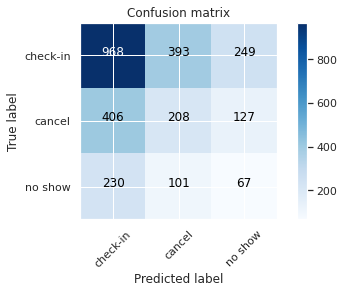

In [ ]:
plot_confusion_matrix(model, pred_valid, y_valid)

Output the prediction results of the test data

In [ ]:
name = '3518_80epo.csv'
out = pd.read_csv("/content/Hotel-A-test.csv")
out = pd.DataFrame(out['Reservation-id'])
out['Reservation_status'] = np.argmax(model.predict(X_test), axis=-1)+1
out.to_csv(name, index=False)      
files.download(name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Correlation between data columns

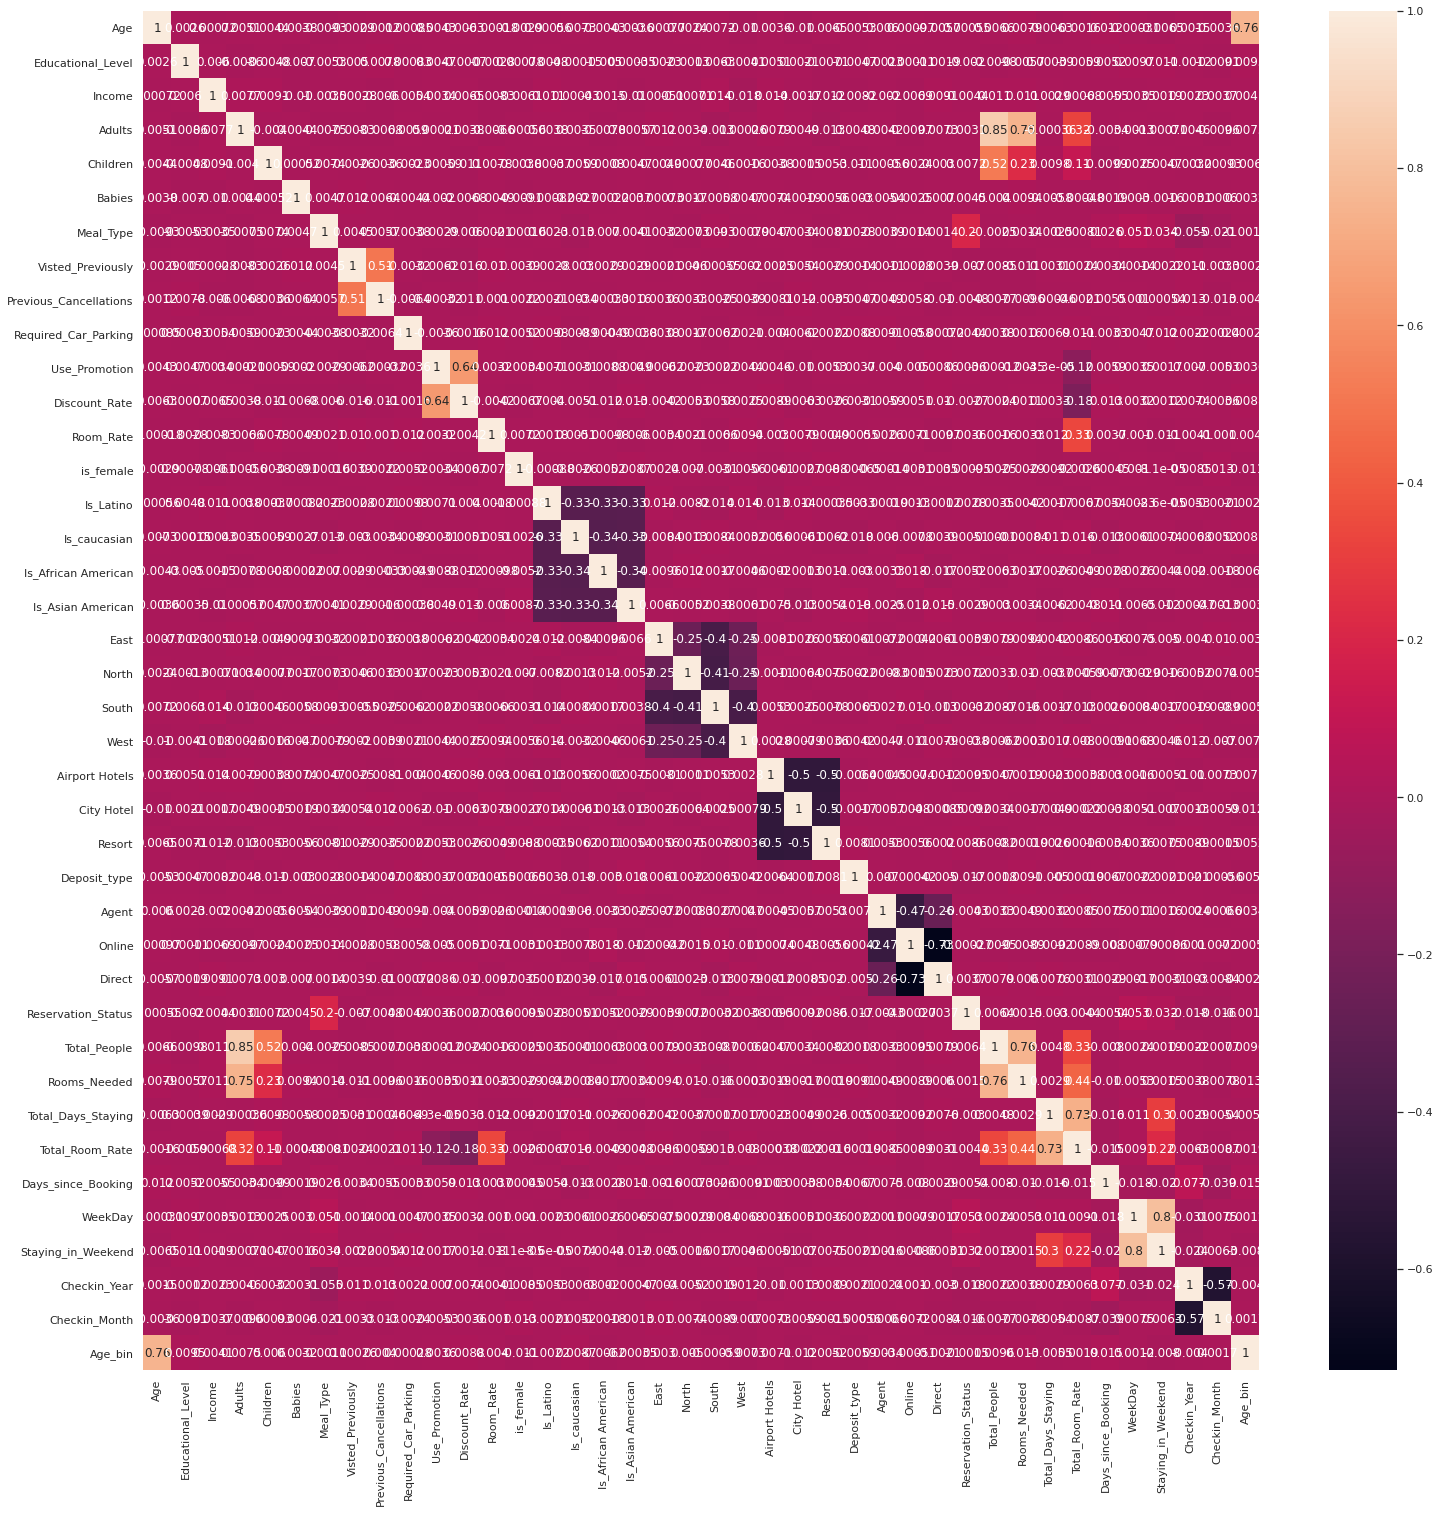

In [ ]:
correlations = train.corr()
plt.figure(figsize=(25,25))
sns.heatmap(correlations, annot=True)